# **Práctico 5 (Parte 6 a): Clustering**

### Tabla de Contenidos
1. [Consigna](#1.-Consigna)
2. [Inicialización del entorno](#2.-Inicialización-del-entorno)
3. [Carga del word embeddings](#3.-Carga-del-word-embedding)
4. [Carga de datos de los dialogos](#4.-Carga-de-datos-de-los-dialogos)
5. [Cálculo de los vectores promedio](#5.-Cálculo-de-los-vectores-promedio)
6. [Clustering con K Means: explorar el número de clusters](#6.-Clustering-con-K-Means:-explorar-el-número-de-clusters)
7. [Clustering con K Means: evaluación](#7.-Clustering-con-K-Means:-evaluación)

## 1. Consigna


1) Ahora usaremos un algoritmos de clustering como k-means a los word-embeddings de un diálogo. Una estrategia sencilla para calcular el word-embedding de un diálogo es sumar todos los word embeddings de las palabras del diálogo y dividirlas por la cantidad de palabras del diálogo. Naturalmente usaríamos 2 clusters porque es una clasificación binaria. ¿Tendría sentido usar 3 clusters o más?

2) Repetir lo mismo pero usando sólo el ultimo 25% del diálogo (los ultimos turnos).   

3) Evaluar la distribución de los diálogos positivos y negativos en clusters. 

## 2. Inicialización del entorno

In [1]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import re
from ast import literal_eval
import itertools
import random

# Tratamiento de emojis
from utiles import convert_emojis
from utiles import convert_emoticons

# Embeddings
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Clustering
from nltk.cluster import KMeansClusterer
import nltk

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## 3. Carga del word embedding

Cargamos uno de los word embeddings obtenidos en el proceso del práctico anterior [Practico_5_part_4](Practico_5_part_4.ipynb)

In [2]:
#1. Archivo y directorio del embedding
embedding_dir = os.path.join('..', 'dataset/embeddings')
embedding_file = '20201007-003333_model_1000-5-100-1.bin'
embedding_file_full = os.path.join(embedding_dir, embedding_file)

In [3]:
#2 Carga del modelo
model = Word2Vec.load(embedding_file_full)

In [4]:
#3 Información sobre el embedding
print('\nTamaño del vocabulario del modelo: {} palabras'.format(len(list(model.wv.vocab))))
print('\nTamaño de los vectores del modelo: {}-D'.format(model.vector_size))


Tamaño del vocabulario del modelo: 2591 palabras

Tamaño de los vectores del modelo: 1000-D


## 4. Carga de datos de los dialogos

Cargamos los dialogos para procesarlos con el embedding antes de realizar la operación de agrupamiento 

In [5]:
#1. Carga de los datos de los dialogos
filename = 'yup_curated_data.csv'
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))

In [6]:
#2. Remoción de las sesiones de pocos dialogos
n_short_sessions = len(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)])
datos_curados = datos_curados.drop(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)].index)

#3. Remoción de los dialogos sin contenido
n_null_token_tutor = datos_curados['tokens_tutor'].isnull().sum()
n_null_token_student = datos_curados['tokens_student'].isnull().sum()
datos_curados = datos_curados.dropna(subset=['tokens_tutor','tokens_student'])

datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: literal_eval(x))
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: literal_eval(x))

#4. Utilizamos expresiones regulares para unificar los unigramas bajo el tag <math>
r = re.compile('((?=.*[0-9])(?=.*[%\/\(\)\^\\\+\-\*\=]))^.*')
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: ['<math>' if r.match(w) else w for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: ['<math>' if r.match(w) else w for w in x])

#5. Reemplazamos emojis
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: [convert_emojis(w) for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: [convert_emojis(w) for w in x])

#6. Reemplazamos emoticons
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: [convert_emoticons(w) for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: [convert_emoticons(w) for w in x])


In [7]:
datos_curados['tokens'] = datos_curados['tokens_tutor'] +  datos_curados['tokens_student']  

## 5. Cálculo de los vectores promedio

In [8]:
#1. Función que calcula el vector resultante 
#   de la suma de los vectores correspondientes a todos los tokens del dialogo 
#   sobre la cantidad de tokens

def vector_promedio(modelo, dialogo):
    l_vectores = [modelo[w] for w in dialogo if w in modelo.vocab.keys()]
    
    if len(l_vectores) == 0:
        vector_resultante = [0.0]*model.vector_size
    else:
        vector_resultante = np.sum(l_vectores, axis=0) / len(l_vectores)
        
    return vector_resultante

In [9]:
#2. Computamos el vector promedio para los tokens del tutor y del estudiante para cada dialogo
datos_curados['vector_promedio_tokens'] = datos_curados['tokens'].apply(lambda x: vector_promedio(model.wv, x))

## 6. Clustering con K Means: explorar el número de clusters

Aunque estamos en presencia del un problema de clasificación binaria, queremos ver cual es la cantidad de grupos óptima para el algoritmo de clustering, en este caso K Means. 
Para eso vamos a explorar el gráfico de inercia y los diagramas de silueta desde 2 a 5 clusters

Aunque el gráfico del codo indicaría que la cantidad óptima de clusters es 3, mediante el análisis de las siluetas obtenemos un coeficientemente claramente superior para 2 clusters.

In [10]:
#1. Nuestro conjunto de datos para realizar la operación de clustering es la resultante del promedio de los dialogos
X = datos_curados['vector_promedio_tokens']

Análisis de Inercia


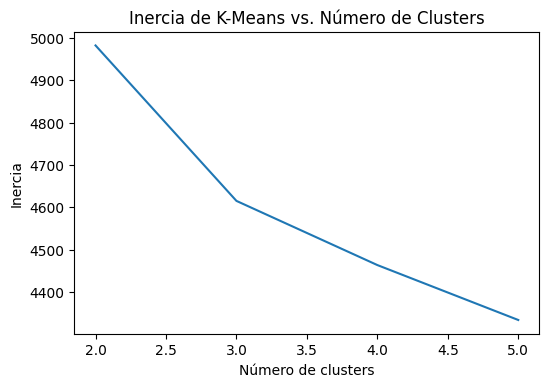


Análisis de Coeficiente de Silueta

Para n_clusters = 2 el coeficiente de silueta promedio es de: 0.35927647
Para n_clusters = 3 el coeficiente de silueta promedio es de: 0.13739747
Para n_clusters = 4 el coeficiente de silueta promedio es de: 0.06516513
Para n_clusters = 5 el coeficiente de silueta promedio es de: 0.055726696


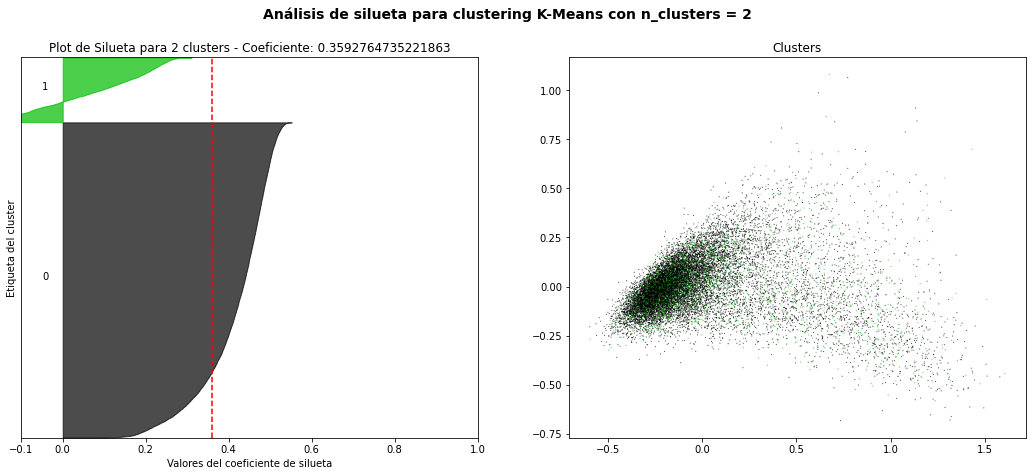

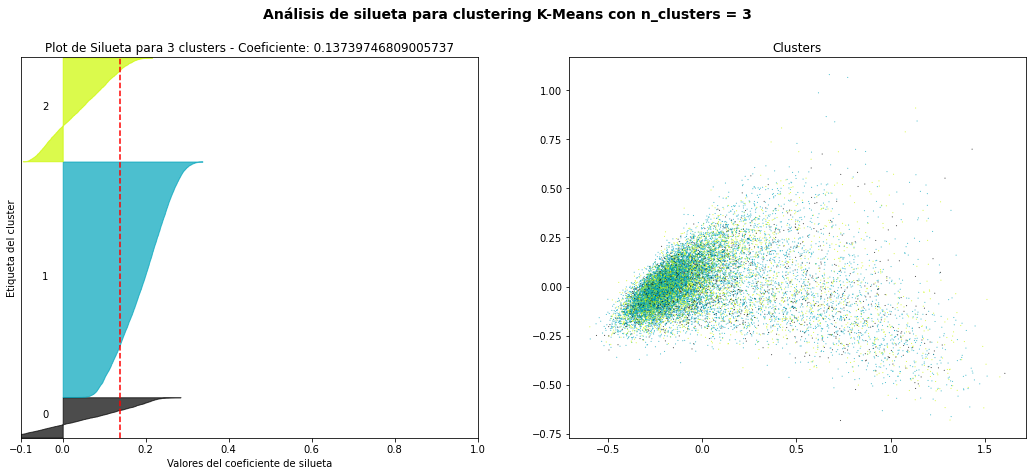

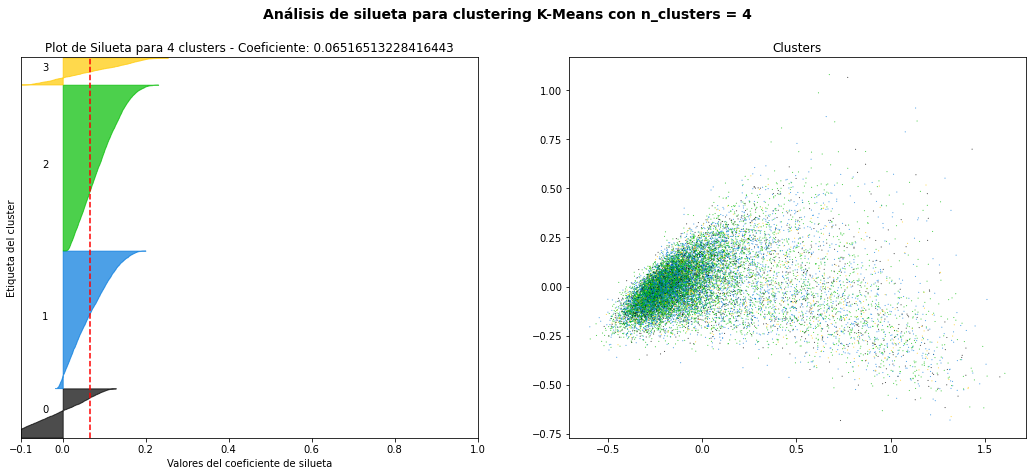

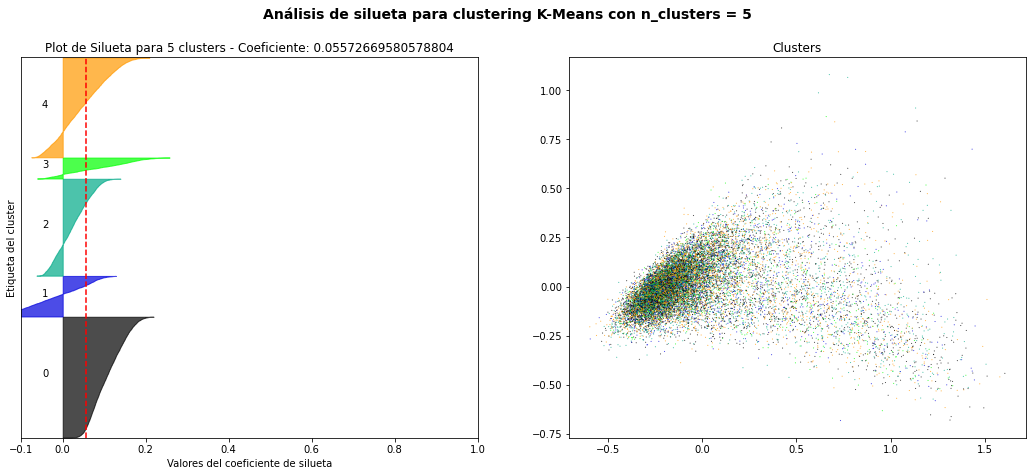

In [11]:
#2. Análisis de Inercia
print('Análisis de Inercia')
fits   = []
scores = []
for i in range(4):
    clusterer = KMeans(n_clusters=i+2, random_state=0)
    fits.append(clusterer.fit(X.tolist()))
    scores.append(fits[i].inertia_)    
plt.figure(dpi=100)
plt.title('Inercia de K-Means vs. Número de Clusters')
plt.plot(np.arange(2, 4+2), scores)
plt.xlabel('Número de clusters')
plt.ylabel("Inercia")
plt.show()

#3. Coeficiente de Silueta    
print('\nAnálisis de Coeficiente de Silueta\n')

for n_clusters in range(2, 5+1):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X.tolist()) + (n_clusters + 1) * 10])
    cluster_labels = fits[n_clusters-2].predict(X.tolist())
    silhouette_avg = silhouette_score(X.tolist(), cluster_labels)
    print("Para n_clusters =", n_clusters, "el coeficiente de silueta promedio es de:", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X.tolist(), cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title('Plot de Silueta para {} clusters - Coeficiente: {}'.format(n_clusters, silhouette_avg))
    ax1.set_xlabel('Valores del coeficiente de silueta')
    ax1.set_ylabel('Etiqueta del cluster')
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)[:len(cluster_labels)-n_clusters+1]
    pca = PCA(n_components=2)
    resultPCA = pca.fit_transform(X.tolist())

    ax2.scatter(resultPCA[i:, 0], resultPCA[i:, 1], marker='.', s=5, lw=0, alpha=0.7, c=colors, edgecolor='k')
    #centers = fits[n_clusters-2].cluster_centers_
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title('Clusters')
    plt.suptitle(('Análisis de silueta para clustering K-Means con n_clusters = %d' % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

## 7. Clustering con K Means: evaluación

In [12]:
#1. Usamos K Means con 2 clusters
clusterer = KMeans(n_clusters=2, random_state=0)
clusters = clusterer.fit(X.tolist())

En el gráfico de silueta para 2 clusters se oberva que el cluster identificado como **0** corresponde a la clase mayoritaria que es nuestra clase **1-Positivo** y el cluster identificado como **1** correspondería a la clase **0-Negativo**.

Vamos a renombrar las etiquetas de los clusters para que la evaluación sea más clara y vamos ver como resultó el clustering comparando con la anotación de los dialogos

In [13]:
#2. Renombramos las etiquetas de los clusters por claridad en la comparación con las clases del problema
datos_curados['label_cluster'] = clusters.labels_
datos_curados['label_cluster'] = datos_curados.label_cluster.apply(lambda x: 0 if x == 1 else 1)

Rápidamente evaluamos cuantos dialogos fueron agrupados en el cluster "correcto"

In [14]:
#3. Calculamos la cantidad de dialogos correctamente agrupados
total_dialogos = len(datos_curados)
dialogos_bien_agrupados = len(datos_curados[datos_curados.student_rating_cat == datos_curados.label_cluster])

print('De un total de {} dialogos {} fueron agrupados correctamente. Esto representa un {} de los dialogos'
      .format(total_dialogos, dialogos_bien_agrupados, dialogos_bien_agrupados/total_dialogos))

De un total de 16305 dialogos 12788 fueron agrupados correctamente. Esto representa un 0.7842992946948789 de los dialogos


Vamos a ver como resulta el agrupamiento con respecto a las dos clases de nuestro problema

In [15]:
#4. Creamos una tabla cruzada normalizada para visualizar el agrupamiento con respecto a las clases
tabla = pd.crosstab(index=datos_curados['label_cluster'], columns=datos_curados['student_rating_cat'])
tabla_normalizada = tabla/tabla.sum(axis=0)

print('Tabla cruzada de la clase respecto del cluster asignado')
with pd.option_context('display.precision', 4):
    display(tabla_normalizada)

Tabla cruzada de la clase respecto del cluster asignado


student_rating_cat,0,1
label_cluster,,
0,0.3797,0.121
1,0.6203,0.879


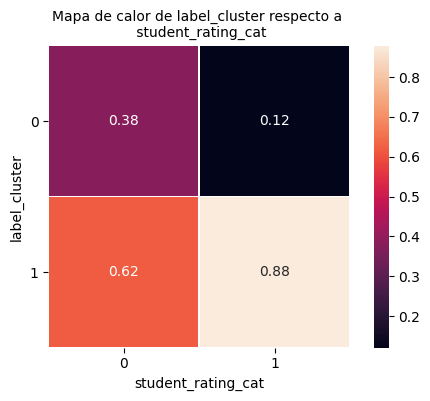

In [16]:
#5. Y un mapa de calor para visualizar los datos graficamente
plt.figure(dpi=100)
plt.title('Mapa de calor de {} respecto a \n {}'.format('label_cluster', 'student_rating_cat'), fontsize=10)
ax = sns.heatmap(tabla_normalizada, annot=True, 
                          fmt= ".2f",
                          square=True, linewidths=.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()


Vemos que los dialogos de la clase mayoritaria se han agrupado correctamente en una proporción mayor de lo que lo han hecho los dialogos de la clase negativa